Created for mirmos proposal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import corner

from platon.fit_info import FitInfo
from platon.retriever import Retriever
from platon.constants import R_sun, R_jup, M_jup

from platon.transit_depth_calculator import TransitDepthCalculator
from platon.constants import M_jup, R_sun, R_jup
from platon.abundance_getter import AbundanceGetter


# All quantities in SI
Rs = 1.16 * R_sun     #Radius of star
Mp = 1.00 * M_jup     #Mass of planet
Rp = 1.00 * R_jup      #Radius of planet
T = 1200.              #Temperature of isothermal part of the atmosphere


from pylab import *

In [9]:
SPECTRAL_RES = 300

In [10]:
bins = []
l = 0.95
waves = [0.7]
bins = [[0.65, 0.75]]

while l < 2.45:
    dl = l/SPECTRAL_RES
    bins.append([l, l+dl])
    waves.append(l)
    l += dl
    
    
bins2 = []
l = 0.65
waves2 = [0.7]
bins2 = [[0.65, 0.75]]

while l < 2.45:
    dl = l/(SPECTRAL_RES*2)
    bins2.append([l, l+dl])
    waves2.append(l)
    l += dl
    
bins,bins2 = map(lambda x: np.array(x)/1e6, [bins, bins2])

Wavelengths that define out of band regions

In [11]:
oobs = [[0.8, 0.972], [1.124, 1.153], [1.352, 1.466], [1.807, 1.921]]

In [12]:
dat1 = np.loadtxt("atran.smo.12555.dat.txt")
dat2 = np.loadtxt("atran.smo.12560.dat.txt")
_, latm1, tatm1 = dat1.T
_, latm2, tatm2 = dat2.T

latm = np.concatenate([latm2, latm1])/1e6
tatm = np.concatenate([tatm2, tatm1])


In [13]:
l = np.array(waves)
in_band = ((l>0.6) & (l<.8)) | \
            ((l>0.972) & (l < 1.124)) | \
            ((l > 1.153) & (l < 1.352)) |\
            ((l>1.466) & (l<1.807)) |\
            ((l>1.921) & (l<2.404))
oob = l>0

depth_calculator = TransitDepthCalculator()
depth_calculator.change_wavelength_bins(bins)
wavelengths, transit_depths = depth_calculator.compute_depths(
    Rs, Mp, Rp, T, CO_ratio=0.2, cloudtop_pressure=1e6, add_scattering=True,
    scattering_slope=4, scattering_factor=10)

model_calc = TransitDepthCalculator()
model_calc.change_wavelength_bins(bins2)
mw, md = model_calc.compute_depths(
    Rs, Mp, Rp, T, CO_ratio=0.2, cloudtop_pressure=1e6, add_scattering=True,
    scattering_slope=4, scattering_factor=10)


errors = np.zeros_like(transit_depths)
errors[:] = 30e-6

In [14]:
for ix,dl in enumerate(bins):
    roi = (latm>dl[0]) & (latm<=dl[1])
    trans = np.median(tatm[roi])
    snr_max = 1/20e-6
    N_obs = snr_max**2 * trans

    errors[ix] = 1/np.sqrt(N_obs)

errors[0] = 20e-6


for oob in oobs:
    roi = (wavelengths*1e6>oob[0]) & (wavelengths*1e6<=oob[1])
    errors[roi] = 0

/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


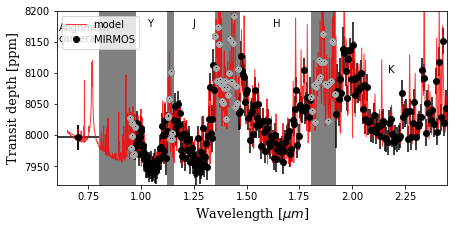

In [17]:

font = {'family' : 'serif',
      'weight' : 'normal',
      'size'   : 13}

    
#rc('font', font=font)
#rc('xtick', labelsize='large')
#rc('ytick', labelsize='large')

figure(figsize=(7, 3.2))
#title(" Spectrum of a Hot Jupiter Transit Observed with MIRMOS")

mus = transit_depths*1e6
sigs = errors*1e6
vals = np.random.randn(len(mus))*sigs + mus

if False:
    plot(l, vals, 'ko')
    errorbar(l, vals, errors*1e6, fmt='k,')
else:
    plot(mw*1e6,md*1e6, color='red', alpha=0.8, lw=1)
    plot(l,transit_depths*1e6, 'ok',)
    errorbar(l, transit_depths*1e6, errors*1e6, fmt='k,')
    errorbar(l[0], transit_depths[0]*1e6, yerr=errors[0]*1e6, xerr=0.1, fmt='k,')
    
for oob in oobs:
    fill_betweenx([0,10000], [oob[0], oob[0]], [oob[1], oob[1]], color='grey')
    roi = (wavelengths*1e6>oob[0]) & (wavelengths*1e6<=oob[1])
    plot(l[roi], transit_depths[roi]*1e6, 'o', color='darkgrey')


xlim(0.6,2.45)
v = 8175
text(0.61, v-25, "Alignment\ncamera")
text(oobs[0][1]*1.06, v, "Y")
text(oobs[1][1]*1.08, v, "J")
text(oobs[2][1]*1.11, v, "H")
text(oobs[3][1]*1.13, 8100, "K")
    
ylim(7920, 8200)

ax = gca()
ax.set_xlabel('Wavelength [$\mu m$]', fontdict=font)
ax.set_ylabel('Transit depth [ppm]', fontdict=font)
legend(["model", "MIRMOS"])


show()

# Dump to file

In [18]:
for ix,dl in enumerate(bins):
    roi = (latm>dl[0]) & (latm<=dl[1])
    trans = np.median(tatm[roi])
    snr_max = 1/20e-6
    N_obs = snr_max**2 * trans

    errors[ix] = 1/np.sqrt(N_obs)

errors[0] = 20e-6


for oob in oobs:
    roi = (wavelengths*1e6>oob[0]) & (wavelengths*1e6<=oob[1])
    errors[roi] = 1

/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


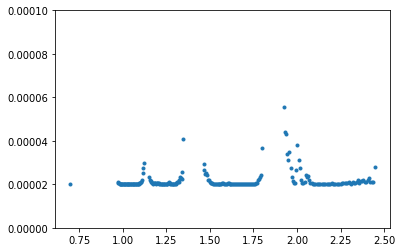

In [22]:
plot(l, errors, '.')
ylim(0,100e-6)
show()

In [56]:
outs = ["Start\t\tStop\t\tUncertainty\t\tExample"]
outs.append("µm\t\tµm\t\t\t\t\tdepth")

for ix, b in enumerate(bins):
    outs.append("%e\t %e\t %e \t\t%e" % (b[0], b[1], errors[ix], transit_depths[ix]))
    
f = open("for_mmin_21-jan-2020.txt", "w")
f.write("\n".join(outs))
f.close()

In [55]:
%pwd

'/Users/npk/Dropbox/REPOS/Konidaris-Research/notebooks/MIRMOS'

# Take hd209548b spectra from Deming+ 2013

1.119 14512.7 50.6 1.121 17545.5 100.4
1.138 14546.5 35.5 1.139 17697.6 97.6
1.157 14566.3 35.2 1.158 17582.1 96.7
1.175 14523.1 34.6 1.177 17772.4 94.8
1.194 14528.7 34.1 1.196 17685.8 93.4
1.213 14549.9 33.7 1.215 17427.6 92.3
1.232 14571.8 33.5 1.234 17386.4 91.6
1.251 14538.6 33.6 1.252 17552.8 91.6
1.270 14522.2 33.8 1.271 17538.6 92.0
1.288 14538.4 33.7 1.290 17435.2 91.5
1.307 14535.9 33.4 1.309 17323.6 90.8
1.326 14604.5 33.4 1.328 17525.0 90.7
1.345 14685.0 33.5 1.347 17696.1 90.7
1.364 14779.0 33.9 1.365 17832.1 91.4
1.383 14752.1 34.4 1.384 17674.6 92.6
1.401 14788.8 34.5 1.403 17569.4 93.0
1.420 14705.2 34.7 1.422 17609.2 93.2
1.439 14701.7 35.0 1.441 17660.1 93.8
1.458 14677.7 35.4 1.460 17923.9 94.7
1.477 14695.1 35.9 1.479 17799.7 96.1
1.496 14722.3 36.4 1.497 17794.9 97.3
1.515 14641.4 36.6 1.516 17771.4 97.9
1.533 14676.8 37.1 1.535 17753.9 98.7
1.552 14666.2 37.8 1.554 17799.1 100.4
1.571 14642.5 38.6 1.573 17590.7 102.4
1.590 14594.1 39.2 1.592 17560.9 104.0
1.609 14530.1 39.9 1.610 17719.4 105.5
1.628 14642.1 40.8 1.629 17650.2 107.7
1.648 17595.9 110.6

In [149]:
lobs = np.array([1.119, 1.138, 1.157, 1.175, 1.194, 1.213, 1.232, 1.251, 1.270, 1.288, 1.307, 1.326, 1.345, 1.364, 1.383, 1.401, 1.420, 1.439, 1.458, 1.477, 1.496, 1.515, 1.533, 1.552, 1.571, 1.590, 1.609, 1.628])

sobs = np.array([14512.7, 
                 14546.5, 
                 14566.3, 
                 14523.1, 
                 14528.7, 
                 14549.9, 
                 14571.8, 
                 14538.6, 
                 14522.2, 
                 14538.4, 
                 14535.9, 
                 14604.5, 
                 14685.0, 
                 14779.0, 
                 14752.1, 
                 14788.8, 
                 14705.2, 
                 14701.7, 
                 14677.7, 
                 14695.1, 
                 14722.3, 
                 14641.4, 
                 14676.8, 
                 14666.2, 
                 14642.5, 
                 14594.1, 
                 14530.1, 
                 14642.1])

In [150]:
Rs = 1.185 * R_sun     #Radius of star
Mp = 0.71 * M_jup     #Mass of planet
Rp = 1.35 * R_jup      #Radius of planet
T = 1500.              #Temperature of isothermal part of the atmosphere



In [160]:
SPECTRAL_RES = 100

bins = []
l = 0.95
waves = [0.7]
bins = [[0.65, 0.75]]

while l < 2.45:
    dl = l/SPECTRAL_RES
    bins.append([l, l+dl])
    waves.append(l)
    l += dl
    
    
bins2 = []
l = 0.65
waves2 = [0.7]
bins2 = [[0.65, 0.75]]

while l < 2.45:
    dl = l/(50)
    bins2.append([l, l+dl])
    waves2.append(l)
    l += dl
    
bins,bins2 = map(lambda x: np.array(x)/1e6, [bins, bins2])

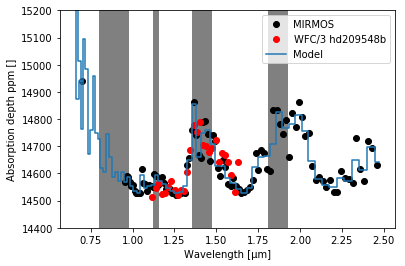

In [161]:

CO = 0.2
PRES=0.8e3
logz=-0.8

depth_calculator = TransitDepthCalculator()
depth_calculator.change_wavelength_bins(bins)
wavelengths, transit_depths = depth_calculator.compute_depths(
    Rs, Mp, Rp, T, CO_ratio=CO, logZ=logz, cloudtop_pressure=PRES, add_scattering=True,
    scattering_slope=4, scattering_factor=10)



model_calc = TransitDepthCalculator()
model_calc.change_wavelength_bins(bins2)
mw, md = model_calc.compute_depths(
    Rs, Mp, Rp, T, logZ=-0.8, CO_ratio=0.2, cloudtop_pressure=PRES, add_scattering=True,
    scattering_slope=4, scattering_factor=10)

plot(wavelengths*1e6, transit_depths*1e6, 'ko')
plot(lobs,sobs,'ro')
step(mw*1e6,md*1e6, where='mid')

    
for oob in oobs:
    
    fill_betweenx([0,20000], [oob[0], oob[0]], [oob[1], oob[1]], color='grey')

ylim(14400, 15200)
xlabel("Wavelength [µm]")
ylabel("Absorption depth ppm []")

legend(["MIRMOS", "WFC/3 hd209548b", "Model"])
show()

In [153]:
?model_calc.compute_depths

In [77]:
?step